# Оглавление
1. [Первичный анализ данных](#Первичный-анализ-данных)
    - [Распределение целевой переменной](#Распределение-цены)
    - [Графики зависимости наиболее коррелируемых переменных от цены](#Графики-зависимости-переменных-с-максимальной-корреляцией-и-цены)
    - [Изменение цены дома во времени](#Изменение-цены-дома-во-времени)
    - [Визуализация зависимости категориальных переменных и цены](#Визуализация-зависимости-категориальных-переменных-и-цены)

2. [Обработка датасета](#Обработка-датасета)
    - [Удаление ненужных колонок](#Удаление-ненужных-колонок)
    - [Работа с категориальными переменными](#Работа-с-категориальными-переменными)
    - [Создание новых переменных](#Создаем-новые-переменные)
    - [Работа с колличественными данными](#Нормировка-данных)
    - [Логарифмирование цены](#Логарифмирование-таргет-переменной)
    - [Разделение на обучающую и тестовую выборки](#Cross-validation)
    
3. [Модели - прогнозирование цены](#Модели---прогнозирование-цены)
    - [Линейная регрессия](#Линейная-регрессия)
    - [Lasso](#Lasso)
    - [Ridge](#Ridge)
    - [ElasticNetCV](#ElasticNetCV)
    - [Decision Tree](#DecisionTree)
    - [RandomForest](#RandomForest)
    - [GradientBoosting](#GradientBoosting)
    - [LGBMRegressor](#LGBMRegressor)
    - [Stacking](#Stacking)
    - [Итоги по моделям](#Подведем-итоги-по-моделям)
4. [ANOVA](#Статистический-тест-на-сравнение-средних-для-разных-категориальных-вариантов-одного-признака)

# Первичный анализ данных

**Импортируем датасет в 4 переменных**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
df_train = pd.read_csv('house_prices_train.csv') #df_train6 df_test - для работы и обработки
df_test = pd.read_csv('house_prices_test.csv')
train_clean = pd.read_csv('house_prices_train.csv') #train_clean, test_clean - для перепроверок и работы с оригинальными данными
test_clean = pd.read_csv('house_prices_test.csv')

### **Распределение цены**

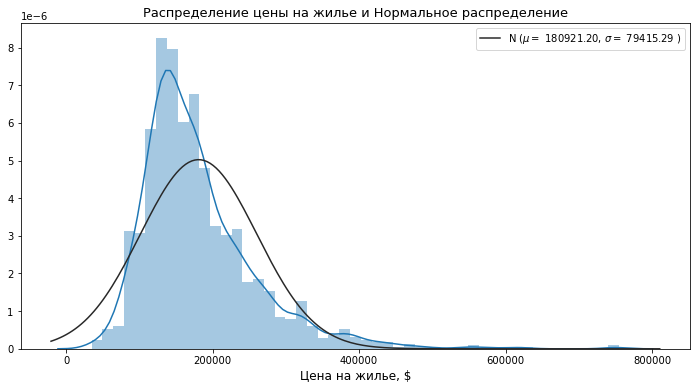

Коэффициент ассиметрии = 1.880940746034036
Он > 0, значит цена распределена не по нормальному закону и имеет больше веса в правом хвосте
Коэффициент эксцесса = 6.509812011089439
Он > 0, значит пик распределения около мат. ожидания - острый (при норм. распред = 0)


In [3]:
from scipy.stats import skew, norm, kurtosis
import seaborn as sns

(mu, sigma) = norm.fit(train_clean['SalePrice'])

plt.figure(figsize = (12,6))
sns.distplot(train_clean['SalePrice'], kde = True, hist=True, fit = norm)
plt.title('Распределение цены на жилье и Нормальное распределение', fontsize = 13)
plt.xlabel("Цена на жилье, $", fontsize = 12)
plt.legend(['N ($\mu=$ {:.2f}, $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.show()
print(f'Коэффициент ассиметрии = {skew(train_clean["SalePrice"])}')
print('Он > 0, значит цена распределена не по нормальному закону и имеет больше веса в правом хвосте')
print(f'Коэффициент эксцесса = {kurtosis(train_clean["SalePrice"])}')
print('Он > 0, значит пик распределения около мат. ожидания - острый (при норм. распред = 0)')

По вычисленным статистикам и графику распределения видно, что цена не подчиняется нормальному закону. 

**Построим корреляционную матрицу цены со всеми количественными признаками, чтобы потом построить визуализацию по количественным признакам с наибольшим значением корреляции**

In [4]:
corr_matrix = df_train.corr()[['SalePrice']].sort_values(['SalePrice'], ascending = False).drop(['SalePrice'])

corr_matrix.style.background_gradient(cmap='coolwarm')

,SalePrice
OverallQual,0.790982
GrLivArea,0.708624
GarageCars,0.640409
GarageArea,0.623431
TotalBsmtSF,0.613581
1stFlrSF,0.605852
FullBath,0.560664
TotRmsAbvGrd,0.533723
YearBuilt,0.522897
YearRemodAdd,0.507101


**OverallQual** - категориальная переменная, оценка состояния материалов дома и законченности ремонта в нем (ее не будем визуализировать) <br>
**GrLivArea** - общая площадь жилого помещения в кв. футах <br>
**GarageCars** - сколько машин помещается в гараж дома <br>
**GarageArea** - площадь гаража в кв. футах <br>
**TotalBsmtSF** - площадь фундамента<br>
**1stFlrSF** - площадь 1 этажа<br>

### **Графики зависимости переменных с максимальной корреляцией и цены**

Однозначно видна линейная зависимость между данными переменными и целевой переменной цены. Эти данные необходимо будет взять в объясняющие при дальнейшем построении моделей. 

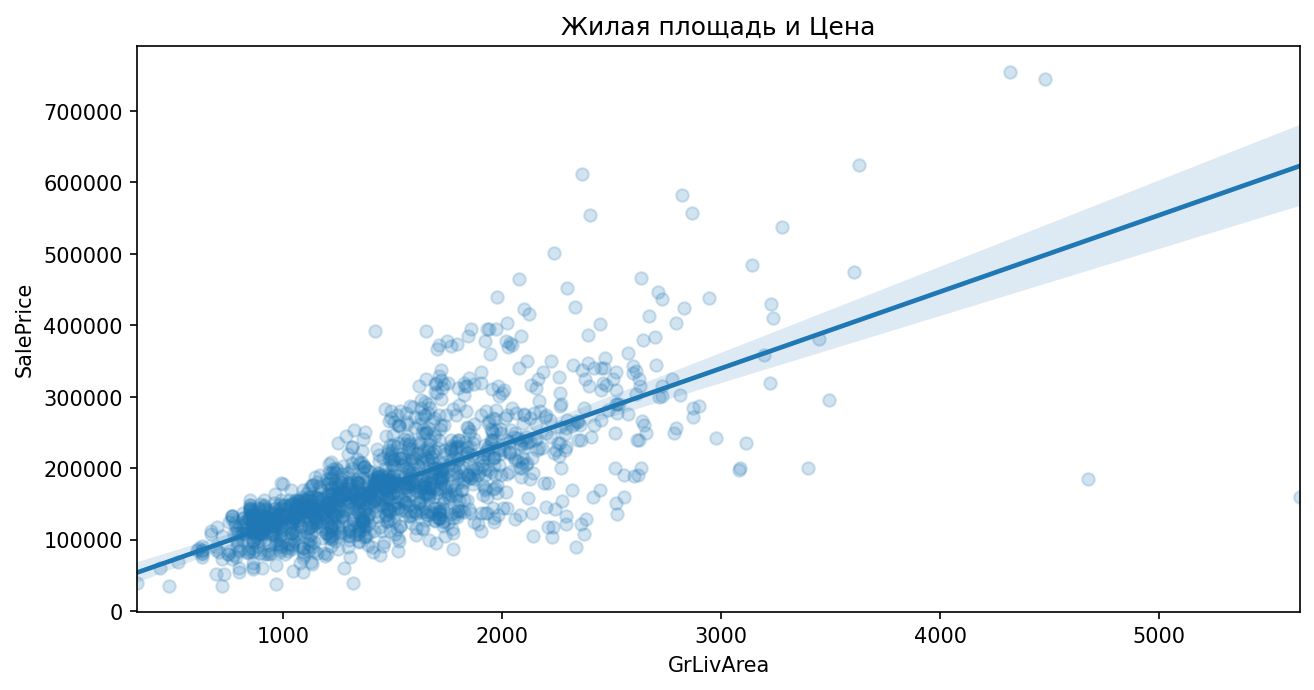

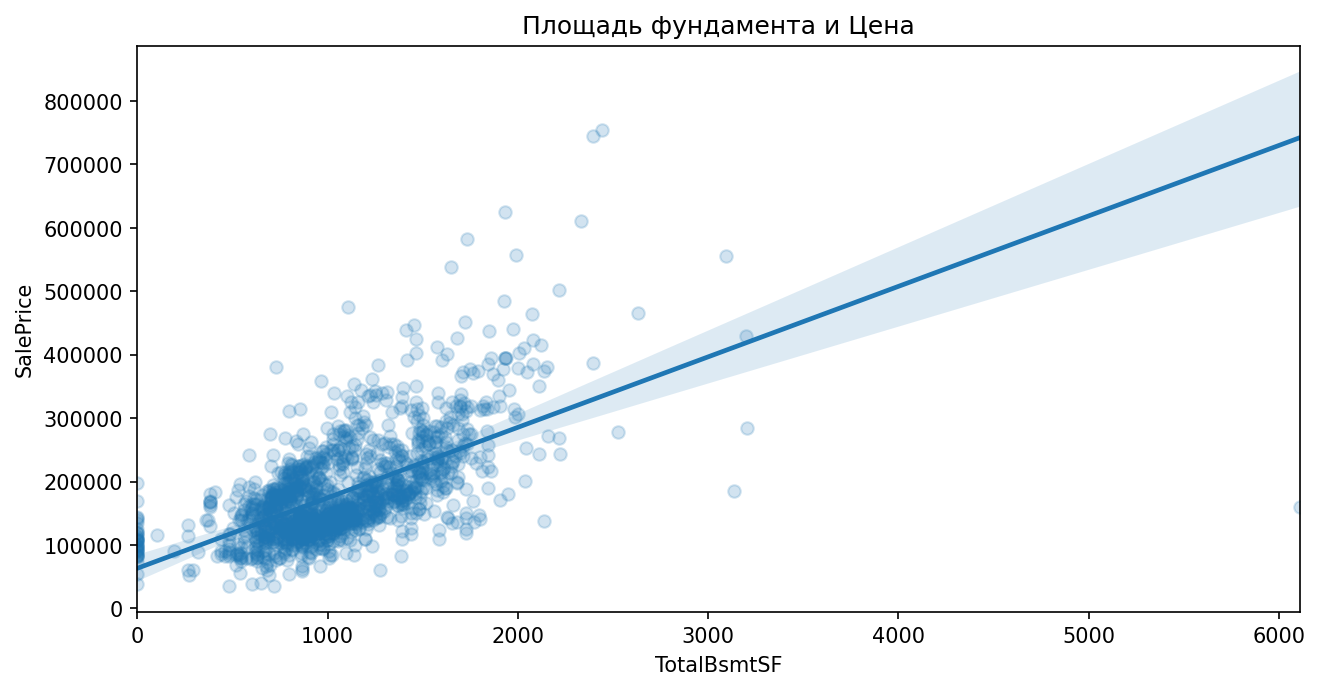

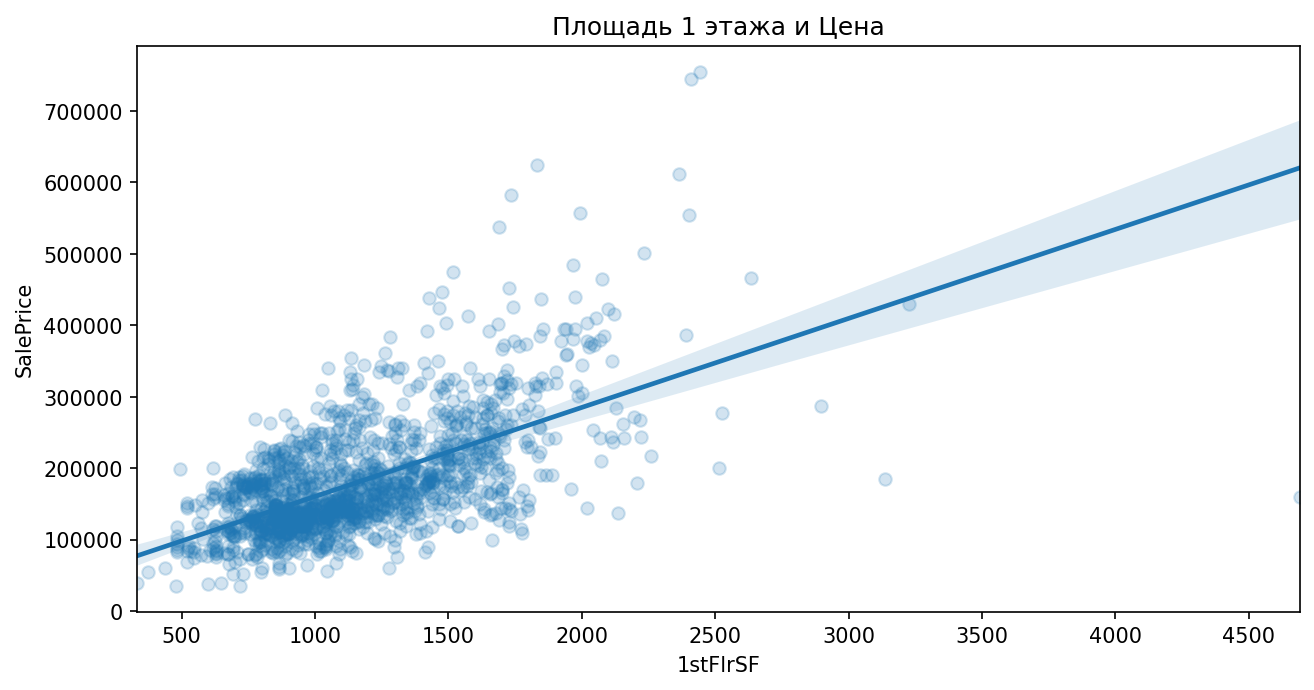

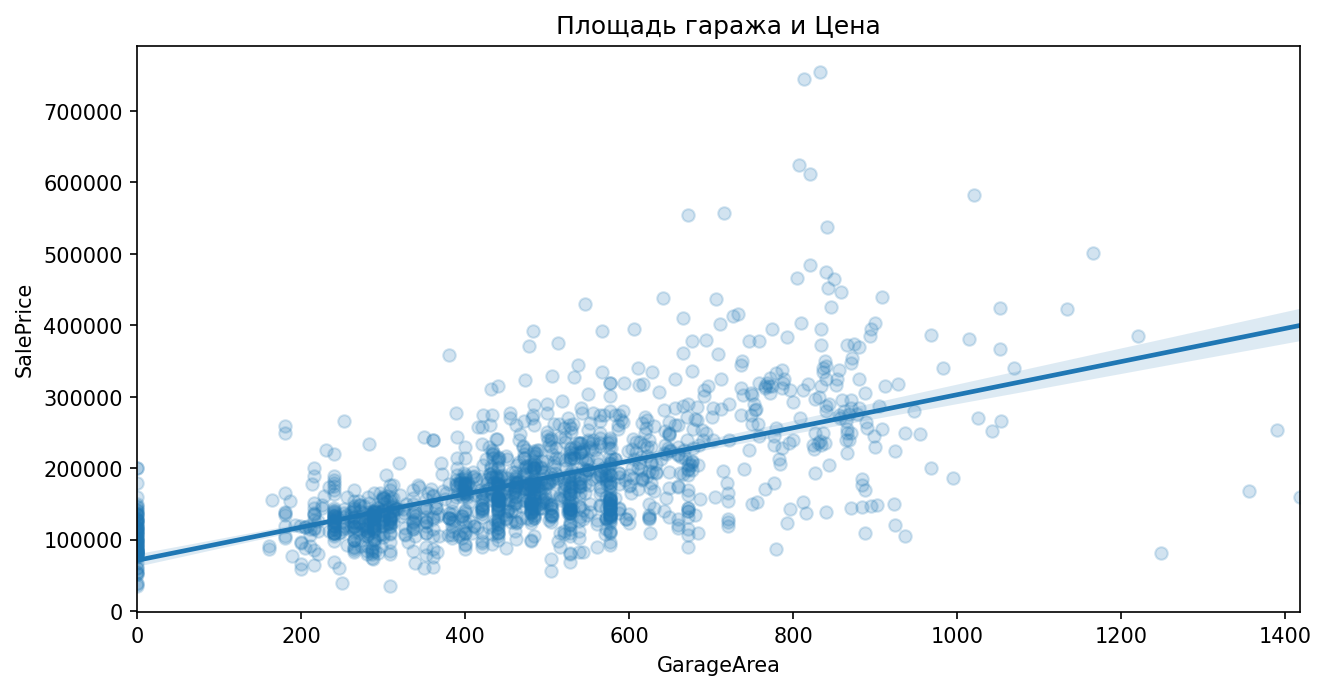

In [5]:
plt.figure(figsize = (10,5), dpi=150)

sns.regplot(data=train_clean, x = 'GrLivArea', y='SalePrice', scatter_kws={'alpha':0.2})
plt.title('Жилая площадь и Цена', fontsize = 12)
plt.show()

plt.figure(figsize = (10,5), dpi=150)
sns.regplot(data=train_clean, x = 'TotalBsmtSF', y='SalePrice', scatter_kws={'alpha':0.2})
plt.title('Площадь фундамента и Цена', fontsize = 12)
plt.show()

plt.figure(figsize = (10,5), dpi=150)
sns.regplot(data=train_clean, x = '1stFlrSF', y='SalePrice', scatter_kws={'alpha':0.2})
plt.title('Площадь 1 этажа и Цена', fontsize = 12)
plt.show()

plt.figure(figsize = (10,5), dpi=150)
sns.regplot(data=train_clean, x = 'GarageArea', y='SalePrice', scatter_kws={'alpha':0.2})
plt.title('Площадь гаража и Цена', fontsize = 12)
plt.show()

### **Изменение цены дома во времени**

**Год постройки дома**

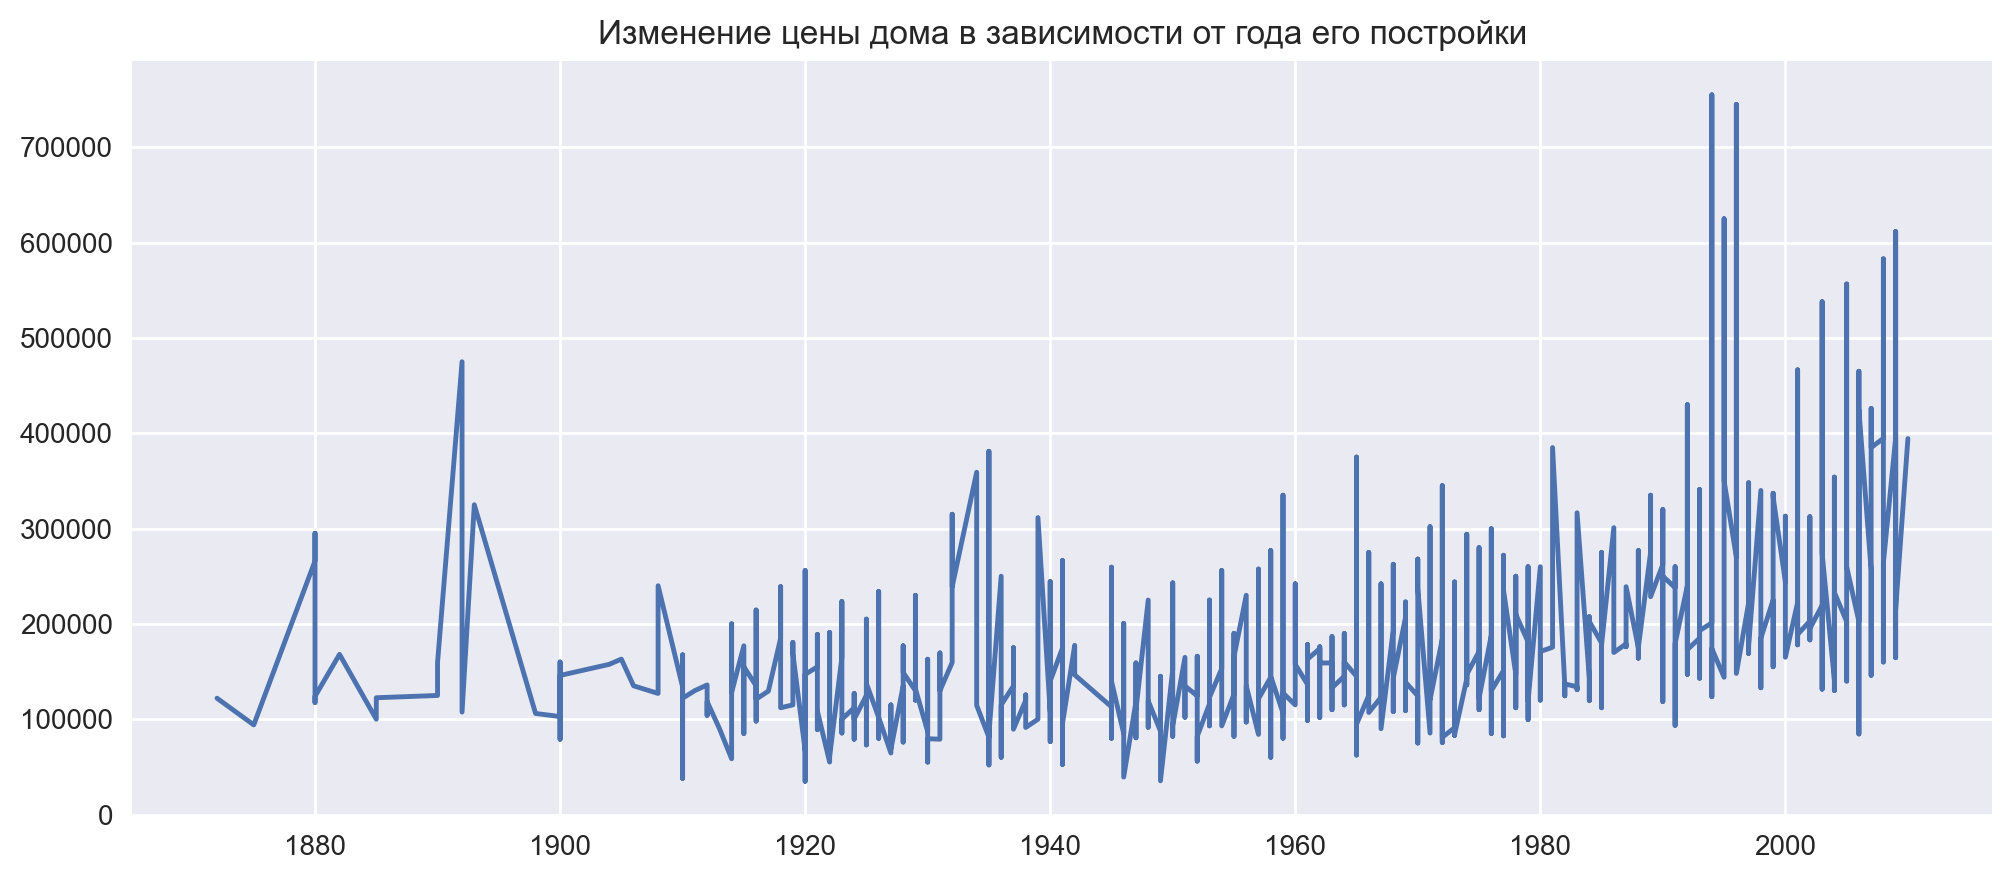

In [6]:
YearBuilt_sales = df_train[['YearBuilt', 'SalePrice']]
YearBuilt_sales = YearBuilt_sales.set_index('YearBuilt')
YearBuilt_sales = YearBuilt_sales.sort_values('YearBuilt')

plt.style.use('seaborn')
plt.figure(figsize=(12,5), dpi=200);
plt.plot(YearBuilt_sales);
plt.title('Изменение цены дома в зависимости от года его постройки');

**Используя скользящее среднее (средняя цена за 50 лет)**

In [7]:
YearBuilt_sales.reset_index(inplace=True)

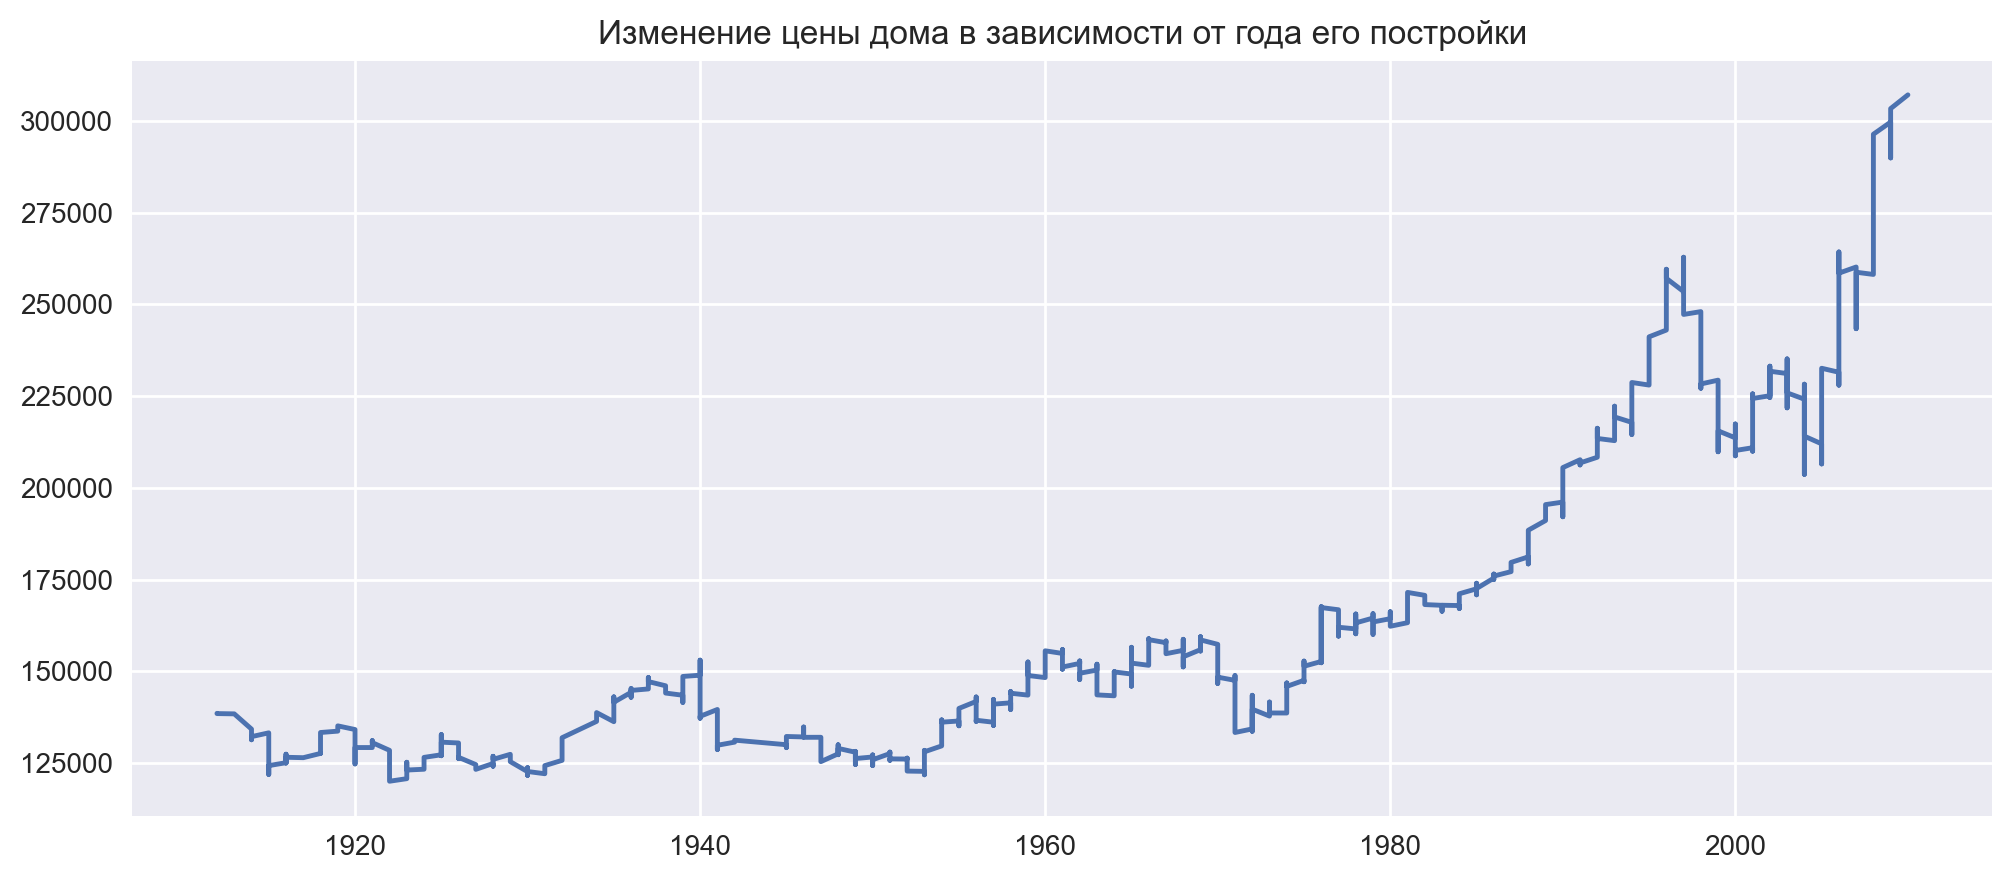

In [8]:
rolling_mean = YearBuilt_sales['SalePrice'].rolling(window=50).mean()
rolling_mean = pd.DataFrame(rolling_mean)
rolling_mean = rolling_mean.set_index(YearBuilt_sales['YearBuilt'])

plt.style.use('seaborn')
plt.figure(figsize=(12,5), dpi=200);
plt.plot(rolling_mean);
plt.title('Изменение цены дома в зависимости от года его постройки');

**Изменение цены дома по времени (год постройки гаража)**

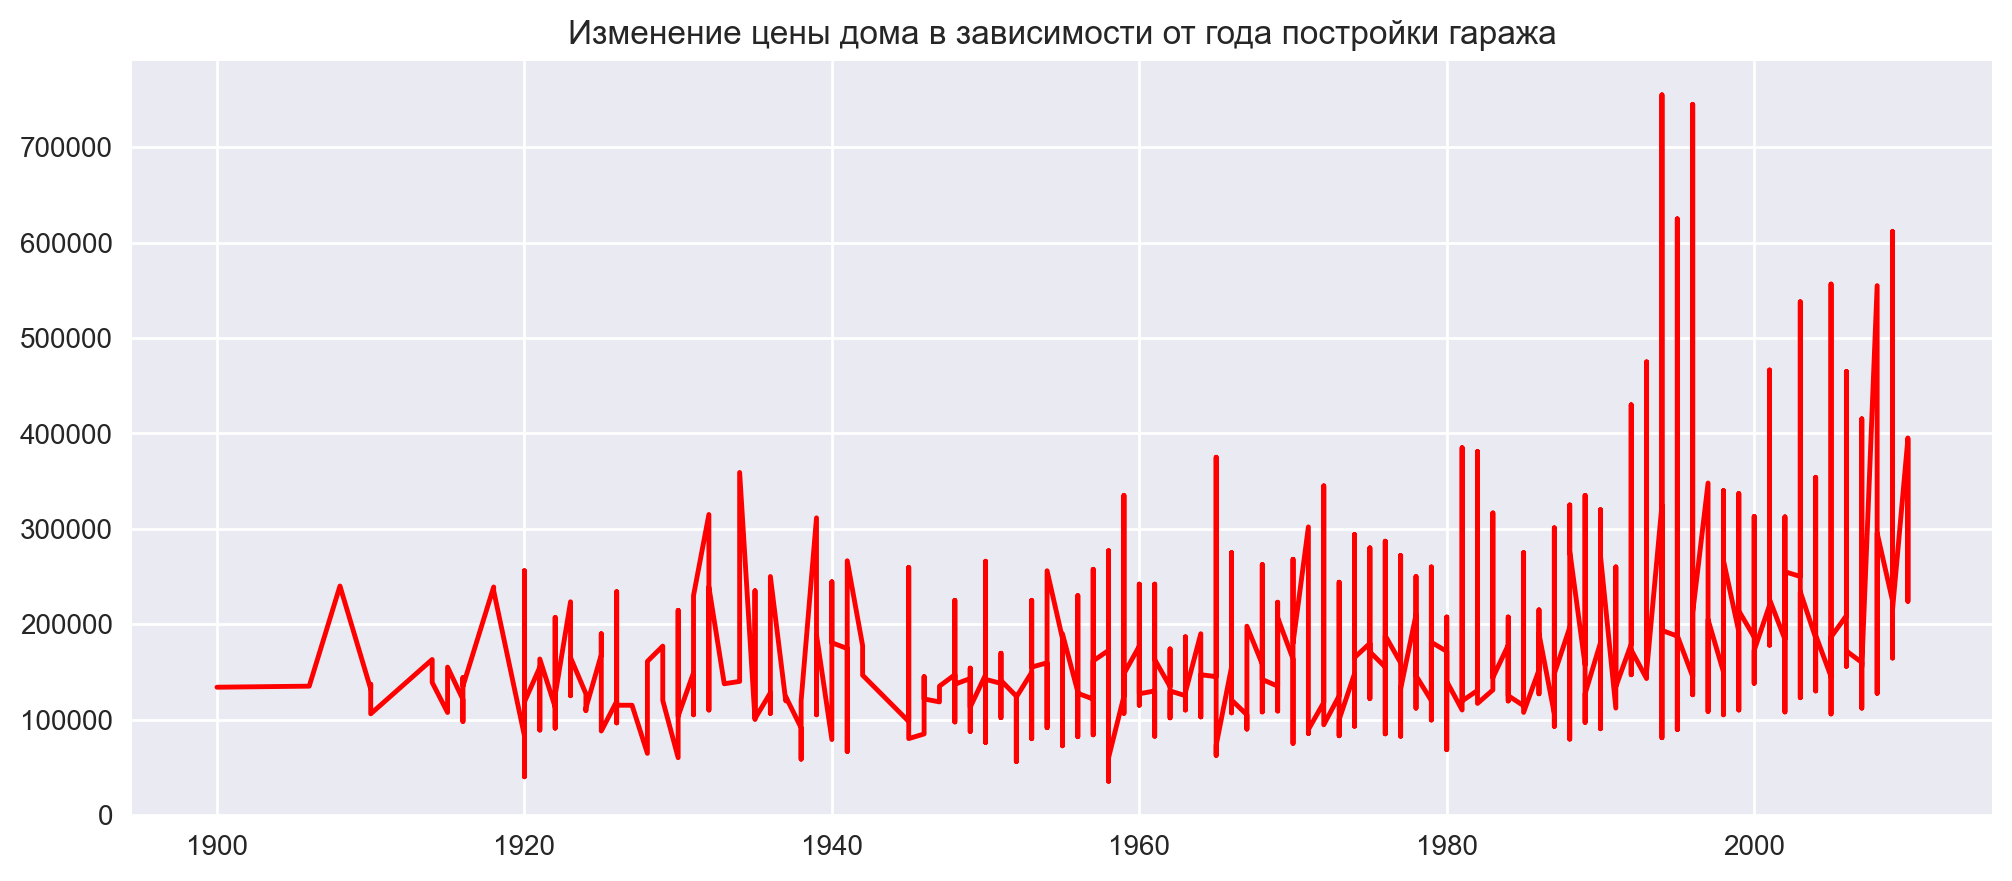

In [9]:
GarageYrBlt_sales = df_train[['GarageYrBlt', 'SalePrice']]
GarageYrBlt_sales = GarageYrBlt_sales.set_index('GarageYrBlt')
GarageYrBlt_sales = GarageYrBlt_sales.sort_values('GarageYrBlt')

plt.style.use('seaborn')
plt.figure(figsize=(12,5), dpi=200);
plt.plot(GarageYrBlt_sales, color='r');
plt.title('Изменение цены дома в зависимости от года постройки гаража');

**Используя скользящее среднее (средняя цена за 50 лет)**

In [10]:
GarageYrBlt_sales.reset_index(inplace=True)

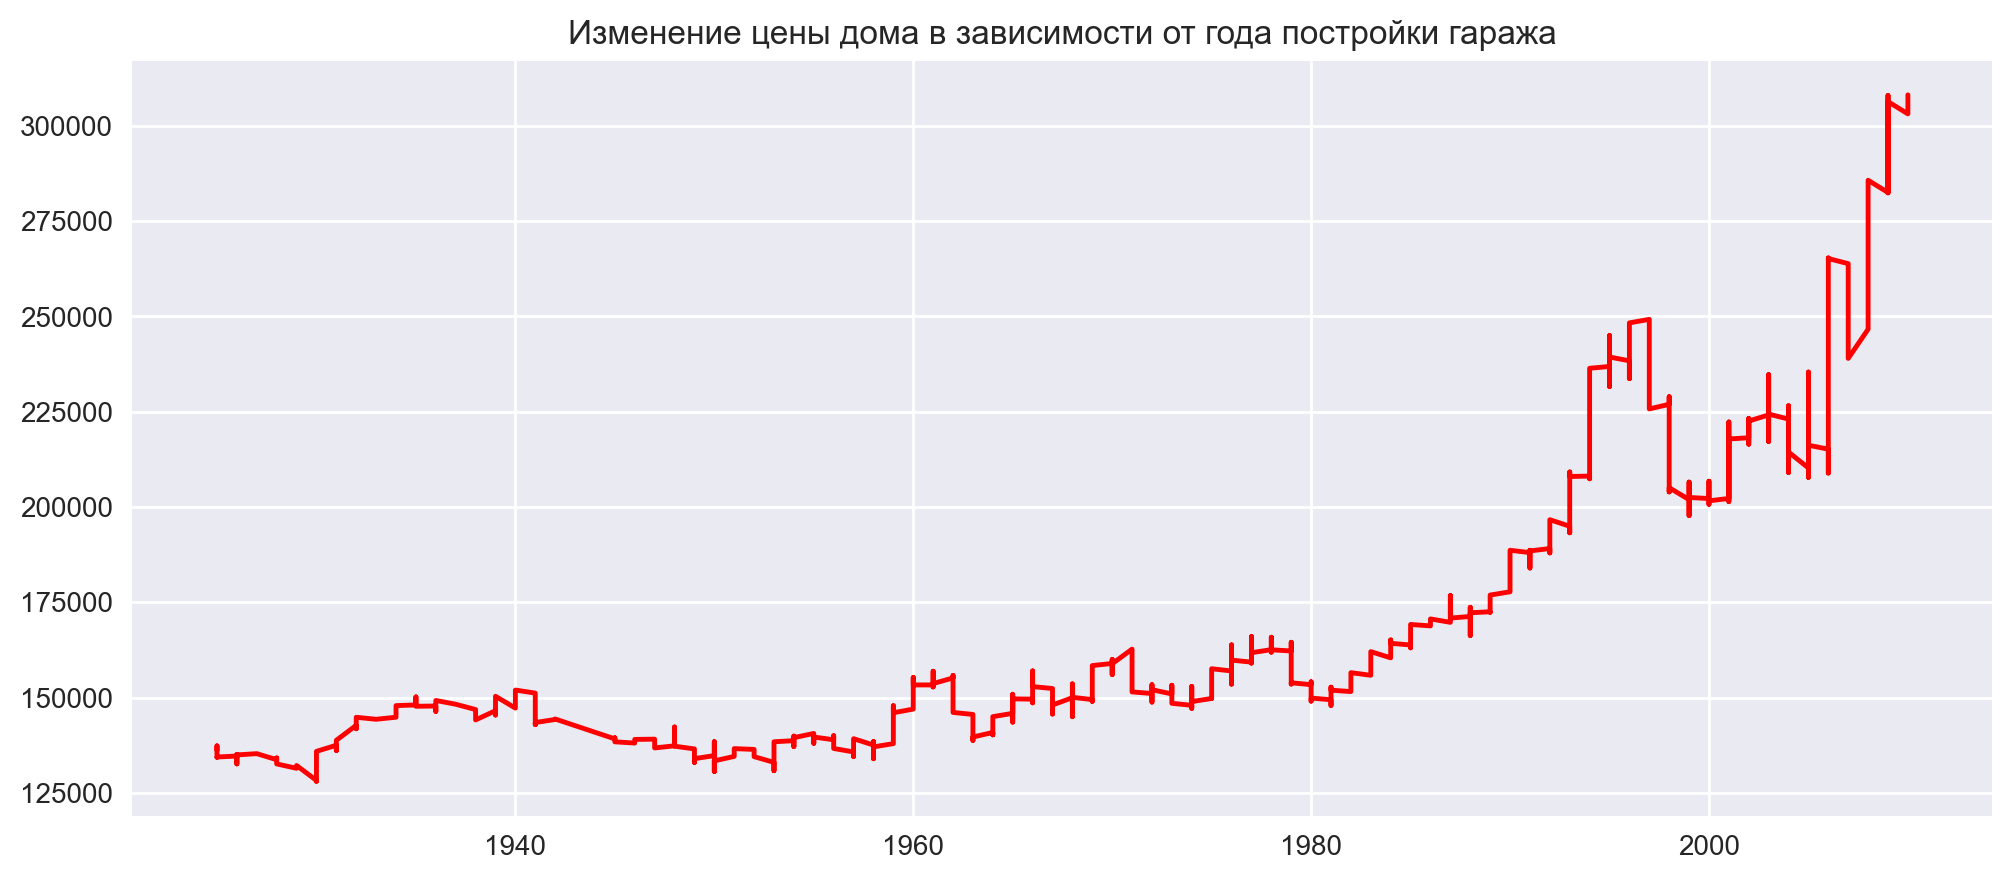

In [11]:
rolling_mean = GarageYrBlt_sales['SalePrice'].rolling(window=50).mean()
rolling_mean = pd.DataFrame(rolling_mean)
rolling_mean = rolling_mean.set_index(GarageYrBlt_sales['GarageYrBlt'])

plt.style.use('seaborn')
plt.figure(figsize=(12,5), dpi=200);
plt.plot(rolling_mean, color='r');
plt.title('Изменение цены дома в зависимости от года постройки гаража');

Переменные YearBuilt и GarageYrBlt - влияют на целевую переменную одинаково и измненение цены во времени (независимо постройка самого дома или постройка гаража в нем) одинаково в обоих случаях, поэтому одну из них можно убрать.

### Визуализация зависимости категориальных переменных и цены

**Проанализируем категориальные переменные (с дискретными значениями)**

**Как влияет тип района на цену дома** <br>
Northridge Heights, Stone Brook - дома класса люкс 

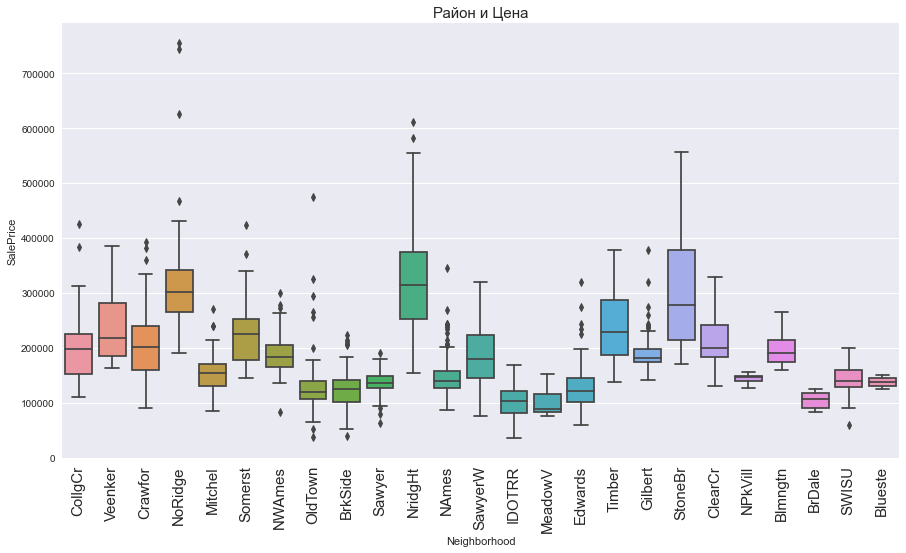

In [12]:
fig, ax = plt.subplots(figsize=(15,8))
sns.boxplot(x='Neighborhood', y='SalePrice', data=df_train, ax=ax);
plt.title('Район и Цена', fontsize=15);
ticks = plt.setp(ax.get_xticklabels(),rotation=90, fontsize=15)

**Как связано состояние дома и цена** <br>
**OverallQual** - состояние дома, переменная у которой была наибольшая корреляция <br>
- 10 Very Excellent
- 9	Excellent
- 8	Very Good
- 7	Good
- 6	Above Average
- 5	Average
- 4	Below Average
- 3	Fair
- 2	Poor
- 1	Very Poor

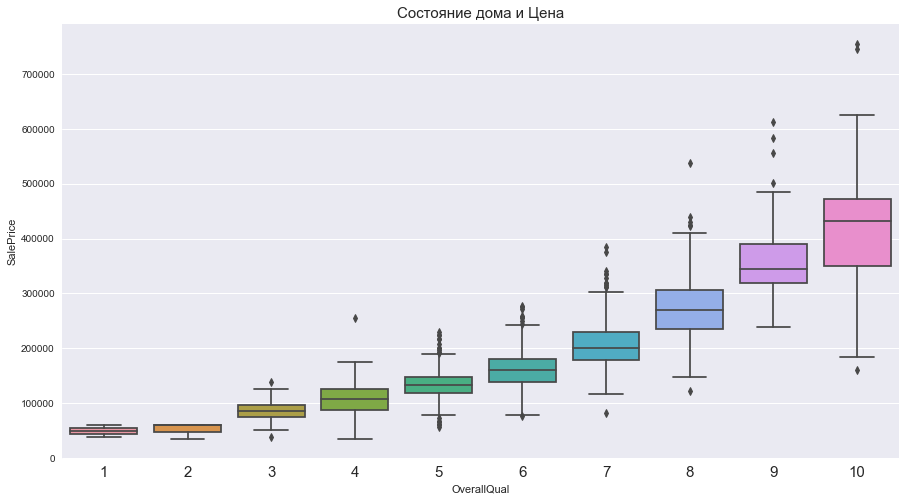

In [13]:
fig, ax = plt.subplots(figsize=(15,8))
sns.boxplot(x='OverallQual', y='SalePrice', data=df_train, ax=ax);
plt.title('Состояние дома и Цена', fontsize=15);
ticks = plt.setp(ax.get_xticklabels(),fontsize=15)

**Условия продажи и цена**

- **Normal**	Normal Sale
- **Abnorml**	Abnormal Sale -  торговля, потеря права выкупа, короткие продажи
- **AdjLand**	Покупка прилегающей земли
- **Alloca**	Allocation - две связанные собственности с отдельными документами, как правило, кондоминиум с гаражом	
- **Family**	Продажа между членами семьи
- **Partial**	Дом не был завершен при последней оценке 

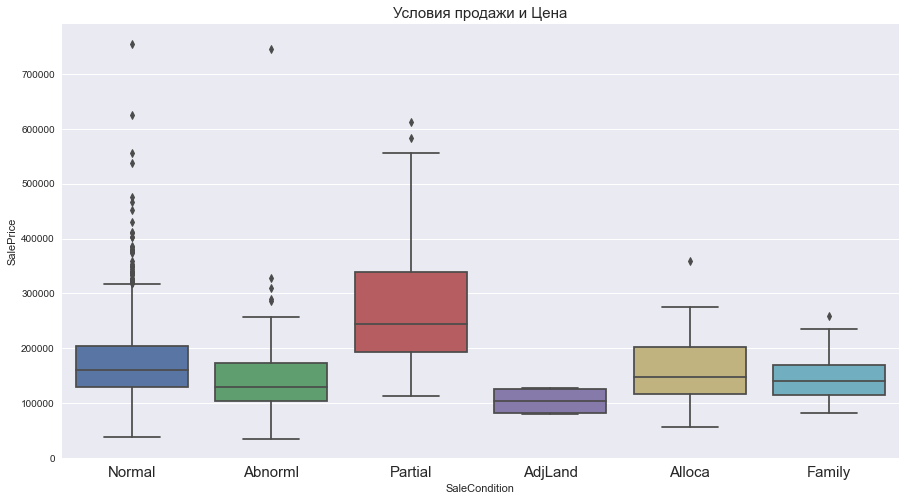

In [14]:
fig, ax = plt.subplots(figsize=(15,8))
sns.boxplot(x='SaleCondition', y='SalePrice', data=df_train, ax=ax);
plt.title('Условия продажи и Цена', fontsize=15);
ticks = plt.setp(ax.get_xticklabels(),fontsize=15)

**Тип продажи и цена дома**
- **WD** 	Гарантийный договор - Обычный (по договоренности)
- **CWD**	Гарантийный договор - Наличные
- **VWD**	Гарантийный договор - Заем 
- **New**	Дом только что построен и продается
- **COD**	Дело судебного исполнителя / наследство
- **Con**	Договор "15% Первоначальный взнос на обычных условиях"
- **ConLw**	Контракт "Низкий первоначальный взнос и низкие проценты"
- **ConLI**	Контракт с низкой процентной ставкой
- **ConLD**	Contract Low Down
- **Oth**	Другое

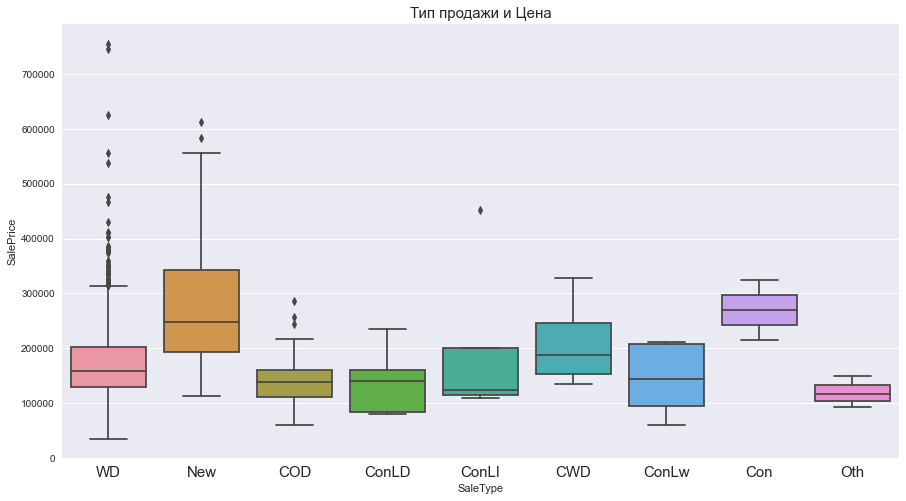

In [15]:
fig, ax = plt.subplots(figsize=(15,8))
sns.boxplot(x='SaleType', y='SalePrice', data=df_train, ax=ax);
plt.title('Тип продажи и Цена', fontsize=15);
ticks = plt.setp(ax.get_xticklabels(),fontsize=15)

**Гараж (тип) и цена**
- **2Types**	Больше чем 1 тип
- **Attchd**	Прямо в доме (присоединен)
- **Basment**	В доме (в фундаменте)
- **BuiltIn**	Встроенный (гаражная часть дома - обычно есть место над гаражом)
- **CarPort**	Навес
- **Detchd**	Отдельно от дома
- **NA**	Нет гаража

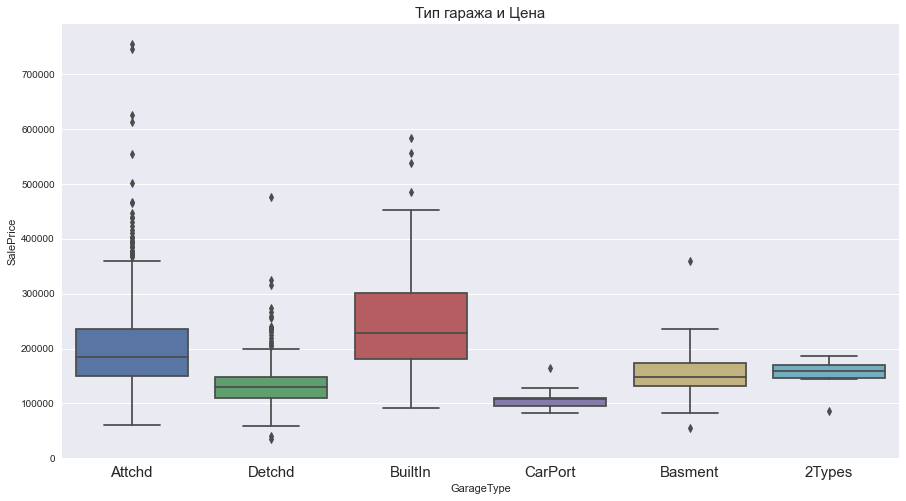

In [16]:
fig, ax = plt.subplots(figsize=(15,8))
sns.boxplot(x='GarageType', y='SalePrice', data=df_train, ax=ax);
plt.title('Тип гаража и Цена', fontsize=15);
ticks = plt.setp(ax.get_xticklabels(),fontsize=15)

**Кол-во комнат и Цена** <br>

**Вместимость гаража и Цена**

Интересно, что в кол-ве комнат и вместимости гаража наблюдается такое явление: до какого-то значения цена растет с возрастанием этих переменных, а при максимальном их значении - падает. То есть цены на дома с 4-мя гаражами в среднем ниже, чем на дома с 3-мя гаражами. 

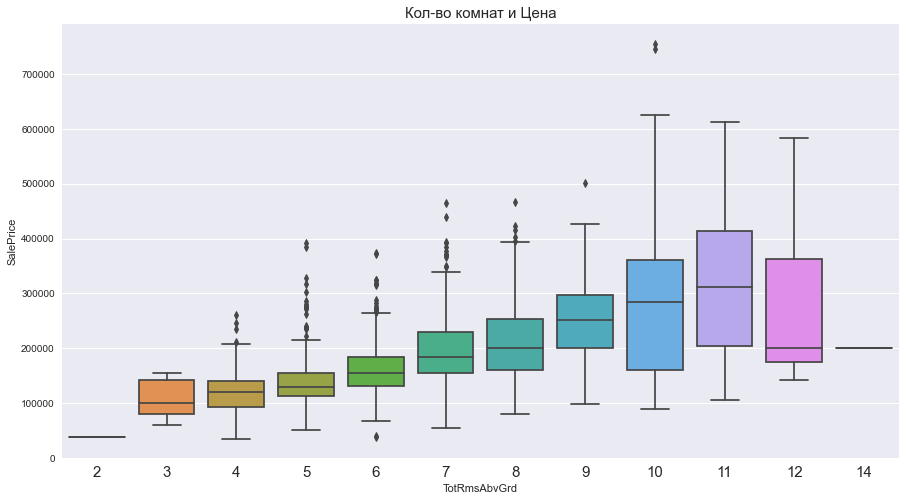

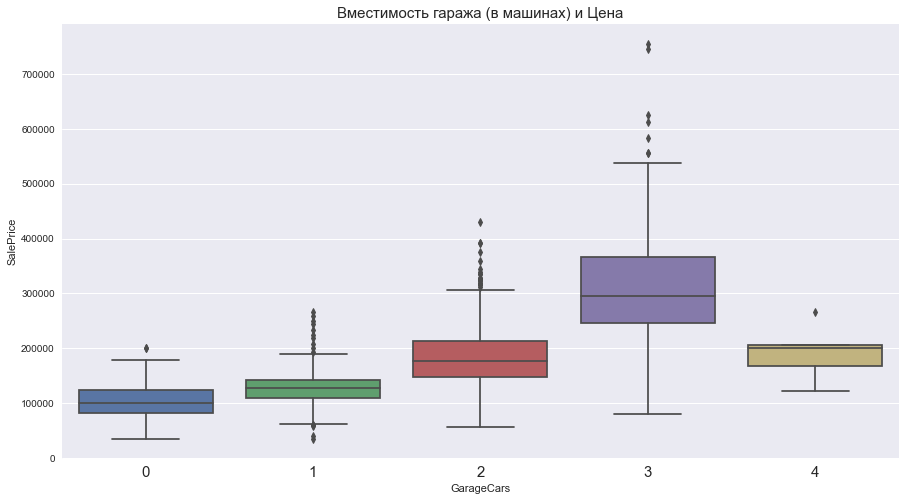

In [17]:
fig, ax = plt.subplots(figsize=(15,8))
sns.boxplot(x='TotRmsAbvGrd', y='SalePrice', data=df_train, ax=ax);
plt.title('Кол-во комнат и Цена', fontsize=15);
ticks = plt.setp(ax.get_xticklabels(),fontsize=15)

fig, ax = plt.subplots(figsize=(15,8))
sns.boxplot(x='GarageCars', y='SalePrice', data=df_train, ax=ax);
plt.title('Вместимость гаража (в машинах) и Цена', fontsize=15);
ticks = plt.setp(ax.get_xticklabels(),fontsize=15)

**Состояние кухни и цена** <br> 

**Состояние камина и цена**<br> 

Очевидно, что чем хуже состояние кухни/камина, тем ниже цена

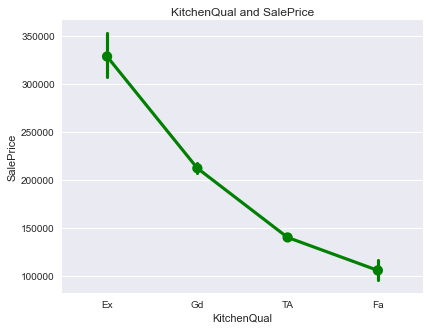

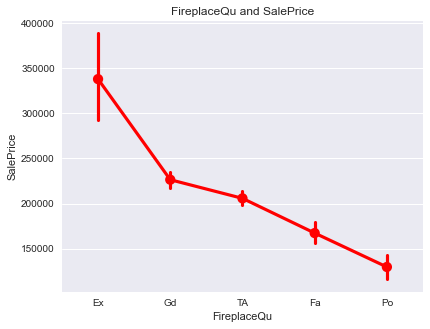

In [18]:
import warnings
warnings.filterwarnings('ignore')

sns.factorplot(data=df_train,x='KitchenQual',y='SalePrice',
               size=4.5,aspect=1.35,
               order=['Ex','Gd','TA','Fa'],
              color='g')
plt.title('KitchenQual and SalePrice');


sns.factorplot(data=df_train,x='FireplaceQu',y='SalePrice',
               size=4.5,aspect=1.35,
               order=['Ex','Gd','TA','Fa', 'Po'],
              color='r')
plt.title('FireplaceQu and SalePrice');

# Обработка датасета

### Удаление ненужных колонок

удалим столбцы где все значения одинаковые 
где везде NAN 
удалим повторящиеся переменные
нормировка
энкодинг

**Удаляем из обучающей выборки целевую переменную и соединяем с тестовой, чтобы обработать весь датасет**

In [19]:
df_train.drop(columns=['SalePrice'], inplace=True)

In [20]:
house = df_train.append(df_test)
house.shape

(2919, 80)

**Удалим столбец PoolQC так как у него почти все значения - пустые**

In [22]:
house = house.drop('PoolQC', axis=1)
house.shape

(2919, 79)

**Удалим колонки, которые почти полностью состоят только из одного значения и колонку id**

In [23]:
house.drop(columns=['Utilities'], inplace=True)
house.drop(columns=['Street'], inplace=True)
house.drop(columns=['Id'], inplace=True)
house.shape

(2919, 76)

### Работа с категориальными переменными

**Посмотрим на пропущенные значения - количественные, чтобы их заполнить либо нулями либо их статистикой (по смыслу)**

In [24]:
#табица количества пропущенных значений и тип данных в столбце
isnull = pd.concat([house.isnull().sum().sort_values(ascending = False), house.dtypes], 
                   axis=1, keys=['Num of NaN', 'Type']) 

In [25]:
#выбираем те столбцы, где есть пропущенные значения
#и где тип данных - float (количественные)
isnull[isnull['Num of NaN'] > 0][isnull['Type']=='float64'] 

,Num of NaN,Type
LotFrontage,486,float64
GarageYrBlt,159,float64
MasVnrArea,23,float64
BsmtHalfBath,2,float64
BsmtFullBath,2,float64
TotalBsmtSF,1,float64
BsmtUnfSF,1,float64
BsmtFinSF2,1,float64
BsmtFinSF1,1,float64
GarageCars,1,float64


**LotFrontage** - территория улицы, которая соединяется с участком дома - заполнить средним значением по столбцу<br>

**Все остальные т.к. пропущено всего от 1-20 значений заполнить нулями, по смыслу тоже подходит так как многое там означает, что объекта, чьи свойства выражает столбец, в доме нет и измерять там нечего**

In [26]:
#float (заполняем данные в столбцах с колличественными данными)
house['LotFrontage'].fillna(house['LotFrontage'].mean(), inplace=True)
house['GarageYrBlt'].fillna(0, inplace=True)
house['MasVnrArea'].fillna(0, inplace=True)
house['BsmtHalfBath'].fillna(0, inplace=True)
house['BsmtFullBath'].fillna(0, inplace=True)
house['BsmtFinSF1'].fillna(0, inplace=True)
house['BsmtFinSF2'].fillna(0, inplace=True)
house['BsmtUnfSF'].fillna(0, inplace=True)
house['TotalBsmtSF'].fillna(0, inplace=True)
house['GarageArea'].fillna(0, inplace=True)
house['GarageCars'].fillna(0, inplace=True)

**Сколько пропущено в категориальных данных**

In [27]:
isnull[isnull['Num of NaN'] > 0][isnull['Type']=='object']

,Num of NaN,Type
MiscFeature,2814,object
Alley,2721,object
Fence,2348,object
FireplaceQu,1420,object
GarageCond,159,object
GarageFinish,159,object
GarageQual,159,object
GarageType,157,object
BsmtCond,82,object
BsmtExposure,82,object


**Заполнить пропуски самым часто встречающимся значением**

**MSZoning** - область в которой расположен продаваемый дом

**Electrical** - тип электрической системы

**KitchenQual** - состояние/качество кухни

**Exterior1st** - материал облицовки дома

**Exterior2nd** - материал облицовки дома (если материалов больше одного)

**SaleType** - тип продажи

**Functional** - состояние дома

In [28]:
#object (заполняем данные в столбцах с категориальными данными)
house['MSZoning'].fillna(house['MSZoning'].mode()[0], inplace=True)
house['Electrical'].fillna(house['Electrical'].mode()[0], inplace=True)
house['KitchenQual'].fillna(house['KitchenQual'].mode()[0], inplace=True)
house['Exterior1st'].fillna(house['Exterior1st'].mode()[0], inplace=True)
house['Exterior2nd'].fillna(house['Exterior2nd'].mode()[0], inplace=True)
house['SaleType'].fillna(house['SaleType'].mode()[0], inplace=True)
house['Functional'].fillna(house['Functional'].mode()[0], inplace=True)

**В первых трех переменных процент пропущенных значений больше 80%, то есть эти переменные не несут в себе никакой информации и не должны влиять на целевую переменную, поэтому удалим их**

In [29]:
isnull['% NaN'] = isnull['Num of NaN']/house.shape[0]
isnull.head()

,Num of NaN,Type,% NaN
MiscFeature,2814,object,0.964029
Alley,2721,object,0.932169
Fence,2348,object,0.804385
FireplaceQu,1420,object,0.486468
LotFrontage,486,float64,0.166495


In [30]:
house.shape

(2919, 76)

In [31]:
house.drop(columns=['MiscFeature'], inplace=True)
house.drop(columns=['Alley'], inplace=True)
house.drop(columns=['Fence'], inplace=True)
house.shape

(2919, 73)

### Корреляционная матрица

**Чтобы исключить влияние переменных, которые дублируют друг друга, воспользуемся корреляционной матрицей между объясняющими переменными**

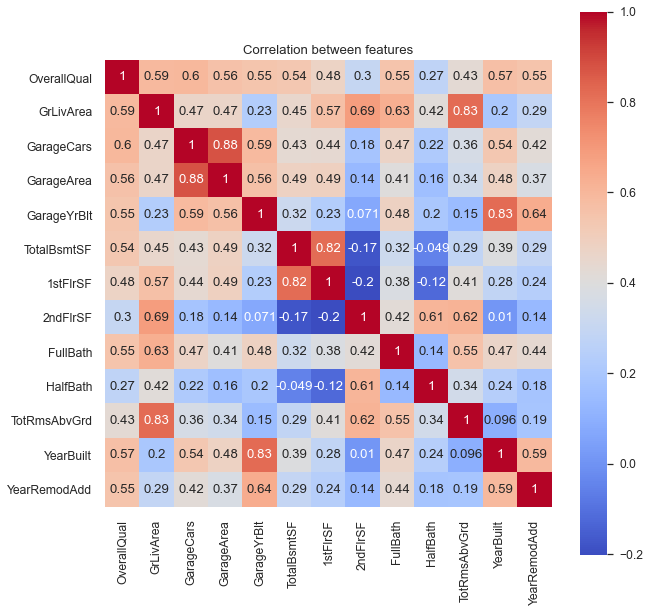

In [32]:
correlation_matrix=df_train[["OverallQual","GrLivArea","GarageCars",
                  "GarageArea","GarageYrBlt","TotalBsmtSF","1stFlrSF","2ndFlrSF", "FullBath","HalfBath",
                  "TotRmsAbvGrd","YearBuilt","YearRemodAdd"]].corr()

sns.set(font_scale=1.10)
plt.figure(figsize=(10, 10))
sns.heatmap(correlation_matrix,
            square=True,annot=True,cmap='coolwarm',linecolor="white")
plt.title('Correlation between features');

TotRmsAbvGrd, FullBath, HalfBath, KitchenAbvGr ~ GrLivArea - можно посчитать Площадь в кв. футах на одну команту <br>
GarageYrBlt ~ YearBuilt (оставим только YearBuilt и преобразуем в Возраст дома) <br>
TotalBsmtSF ~ 1stFlrSF <br>
GarageCars ~ GarageArea <br>

### Создаем новые переменные

In [33]:
house["SFperRoom"] = house["GrLivArea"] / (house["TotRmsAbvGrd"] +
                                            house["FullBath"] +
                                            house["HalfBath"] +
                                            house["KitchenAbvGr"])

house['Home_Quality'] = house['OverallQual'] + house['OverallCond']


house["TotalSF"] = house["1stFlrSF"] + house["2ndFlrSF"]

house['Age'] = (2021-house['YearBuilt'])


In [34]:
house.shape

(2919, 77)

**OneHotEncoding**

In [35]:
house_encoded = pd.get_dummies(house, dummy_na=True, drop_first=True)
house_encoded.shape

(2919, 275)

## Нормировка данных

**Нужно стандартизировать только количественные данные, находим их, сгруппировав по типам**

In [36]:
types = house_encoded.columns.to_series().groupby(house_encoded.dtypes).groups
types

{dtype('uint8'): Index(['MSZoning_FV', 'MSZoning_RH', 'MSZoning_RL', 'MSZoning_RM',
        'MSZoning_nan', 'LotShape_IR2', 'LotShape_IR3', 'LotShape_Reg',
        'LotShape_nan', 'LandContour_HLS',
        ...
        'SaleType_New', 'SaleType_Oth', 'SaleType_WD', 'SaleType_nan',
        'SaleCondition_AdjLand', 'SaleCondition_Alloca', 'SaleCondition_Family',
        'SaleCondition_Normal', 'SaleCondition_Partial', 'SaleCondition_nan'],
       dtype='object', length=235),
 dtype('int64'): Index(['MSSubClass', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt',
        'YearRemodAdd', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea',
        'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd',
        'Fireplaces', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch',
        'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold',
        'Home_Quality', 'TotalSF', 'Age'],
       dtype='object'),
 dtype('float64'): Index(['LotFrontage', 'MasVnrArea', 'Bsm

In [37]:
float_int_cols = ['LotArea', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 
'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd',
'Fireplaces', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', 
'3SsnPorch','ScreenPorch', 'PoolArea','MiscVal', 'TotalSF', 'Age',
'LotFrontage', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF',
'TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath',
'GarageCars', 'GarageArea', 'SFperRoom']


**Создадим отдельную таблицу для данных типа float/int**

In [38]:
house_float_int = house_encoded[['LotArea',
                                 '1stFlrSF',
                                 '2ndFlrSF',
                                 'LowQualFinSF',
                                 'GrLivArea',
                                 'FullBath',
                                 'HalfBath',
                                 'BedroomAbvGr',
                                 'KitchenAbvGr',
                                 'TotRmsAbvGrd',
                                 'Fireplaces',
                                 'WoodDeckSF',
                                 'OpenPorchSF',
                                 'EnclosedPorch',
                                 '3SsnPorch',
                                 'ScreenPorch',
                                 'PoolArea',
                                 'MiscVal',
                                 'TotalSF',
                                 'Age',
                                 'LotFrontage',
                                 'MasVnrArea',
                                 'BsmtFinSF1',
                                 'BsmtFinSF2',
                                 'BsmtUnfSF',
                                 'TotalBsmtSF',
                                 'BsmtFullBath',
                                 'BsmtHalfBath',
                                 'GarageCars',
                                 'GarageArea',
                                 'SFperRoom']]
house_float_int

,LotArea,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,...,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,BsmtFullBath,BsmtHalfBath,GarageCars,GarageArea,SFperRoom
0,8450,856,854,0,1710,2,1,3,1,8,...,196.0,706.0,0.0,150.0,856.0,1.0,0.0,2.0,548.0,142.500000
1,9600,1262,0,0,1262,2,0,3,1,6,...,0.0,978.0,0.0,284.0,1262.0,0.0,1.0,2.0,460.0,140.222222
2,11250,920,866,0,1786,2,1,3,1,6,...,162.0,486.0,0.0,434.0,920.0,1.0,0.0,2.0,608.0,178.600000
3,9550,961,756,0,1717,1,0,3,1,7,...,0.0,216.0,0.0,540.0,756.0,1.0,0.0,3.0,642.0,190.777778
4,14260,1145,1053,0,2198,2,1,4,1,9,...,350.0,655.0,0.0,490.0,1145.0,1.0,0.0,3.0,836.0,169.076923
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1454,1936,546,546,0,1092,1,1,3,1,5,...,0.0,0.0,0.0,546.0,546.0,0.0,0.0,0.0,0.0,136.500000
1455,1894,546,546,0,1092,1,1,3,1,6,...,0.0,252.0,0.0,294.0,546.0,0.0,0.0,1.0,286.0,121.333333
1456,20000,1224,0,0,1224,1,0,4,1,7,...,0.0,1224.0,0.0,0.0,1224.0,1.0,0.0,2.0,576.0,136.000000
1457,10441,970,0,0,970,1,0,3,1,6,...,0.0,337.0,0.0,575.0,912.0,0.0,1.0,0.0,0.0,121.250000


Нормируем

In [39]:
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
scaler = StandardScaler()

norm_house = scaler.fit_transform(house_float_int)
norm_house = pd.DataFrame(norm_house, columns = float_int_cols)
norm_house

,LotArea,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,...,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,BsmtFullBath,BsmtHalfBath,GarageCars,GarageArea,SFperRoom
0,-0.217879,-0.773861,1.207379,-0.101197,0.413547,0.781366,1.232599,0.169927,-0.207698,0.986849,...,0.529034,0.581145,-0.293025,-0.934165,-0.443078,1.087334,-0.249719,0.307040,0.349364,-0.523535
1,-0.072044,0.261075,-0.785025,-0.101197,-0.471891,0.781366,-0.756321,0.169927,-0.207698,-0.287758,...,-0.567016,1.178255,-0.293025,-0.629284,0.477463,-0.818929,3.822508,0.307040,-0.058991,-0.605120
2,0.137197,-0.610718,1.235375,-0.101197,0.563755,0.781366,1.232599,0.169927,-0.207698,-0.287758,...,0.338903,0.098189,-0.293025,-0.287999,-0.297968,1.087334,-0.249719,0.307040,0.627787,0.769481
3,-0.078385,-0.506205,0.978742,-0.101197,0.427382,-1.027363,-0.756321,0.169927,-0.207698,0.349546,...,-0.567016,-0.494529,-0.293025,-0.046824,-0.669812,1.087334,-0.249719,1.619264,0.785561,1.205660
4,0.518903,-0.037170,1.671651,-0.101197,1.378042,0.781366,1.232599,1.385655,-0.207698,1.624153,...,1.390216,0.469187,-0.293025,-0.160586,0.212184,1.087334,-0.249719,1.619264,1.685798,0.428387
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2914,-1.043937,-1.564083,0.488807,-0.101197,-0.807883,-1.027363,1.232599,0.169927,-0.207698,-0.925062,...,-0.567016,-0.968705,-0.293025,-0.033173,-1.145954,-0.818929,-0.249719,-2.317408,-2.193574,-0.738441
2915,-1.049263,-1.564083,0.488807,-0.101197,-0.807883,-1.027363,1.232599,0.169927,-0.207698,-0.287758,...,-0.567016,-0.415500,-0.293025,-0.606531,-1.145954,-0.818929,-0.249719,-1.005184,-0.866421,-1.281675
2916,1.246808,0.164209,-0.785025,-0.101197,-0.546995,-1.027363,-0.756321,1.385655,-0.207698,0.349546,...,-0.567016,1.718287,-0.293025,-1.275450,0.391304,1.087334,-0.249719,0.307040,0.479295,-0.756350
2917,0.034605,-0.483263,-0.785025,-0.101197,-1.049006,-1.027363,-0.756321,0.169927,-0.207698,-0.287758,...,-0.567016,-0.228904,-0.293025,0.032809,-0.316107,-0.818929,3.822508,-2.317408,-2.193574,-1.284660


In [40]:
house_object = house_encoded.drop(columns=float_int_cols)
house_object

,MSSubClass,OverallQual,OverallCond,YearBuilt,YearRemodAdd,GarageYrBlt,MoSold,YrSold,Home_Quality,MSZoning_FV,...,SaleType_New,SaleType_Oth,SaleType_WD,SaleType_nan,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial,SaleCondition_nan
0,60,7,5,2003,2003,2003.0,2,2008,12,0,...,0,0,1,0,0,0,0,1,0,0
1,20,6,8,1976,1976,1976.0,5,2007,14,0,...,0,0,1,0,0,0,0,1,0,0
2,60,7,5,2001,2002,2001.0,9,2008,12,0,...,0,0,1,0,0,0,0,1,0,0
3,70,7,5,1915,1970,1998.0,2,2006,12,0,...,0,0,1,0,0,0,0,0,0,0
4,60,8,5,2000,2000,2000.0,12,2008,13,0,...,0,0,1,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1454,160,4,7,1970,1970,0.0,6,2006,11,0,...,0,0,1,0,0,0,0,1,0,0
1455,160,4,5,1970,1970,1970.0,4,2006,9,0,...,0,0,1,0,0,0,0,0,0,0
1456,20,5,7,1960,1996,1960.0,9,2006,12,0,...,0,0,1,0,0,0,0,0,0,0
1457,85,5,5,1992,1992,0.0,7,2006,10,0,...,0,0,1,0,0,0,0,1,0,0


In [41]:
house_object.shape, norm_house.shape, house_encoded.shape

((2919, 244), (2919, 31), (2919, 275))

In [42]:
house_object.reset_index(drop=True, inplace=True)
norm_house.reset_index(drop=True, inplace=True)

**Получаем готовый датасет (в нем и обучающая и тестовая выборки) с нормированными количественными данными и категориальными данными, к которым применен энкодинг**

In [43]:
house_encoded_norm = pd.concat([house_object, norm_house], axis=1)
house_encoded_norm.shape

(2919, 275)

In [44]:
house_encoded_norm = house_encoded_norm.drop('YearBuilt', axis=1)
house_encoded_norm = house_encoded_norm.drop('GarageYrBlt', axis=1)

**Теперь, когда и train и test приведены в одинаковый вид, общий датасет делим на изначальные две выборки, используя их длину**

In [253]:
train = house_encoded_norm.iloc[:-test_clean.shape[0]]
test = house_encoded_norm.tail(test_clean.shape[0])
train.shape, test.shape, train_clean.shape, test_clean.shape

((1460, 273), (1459, 273), (1460, 81), (1459, 80))

**Добавляем в обучающую выборку прологарифмированную целевую переменную - SalePrice**

In [46]:
train = pd.concat([train, np.log(train_clean['SalePrice'])], axis=1)
train.head()

,MSSubClass,OverallQual,OverallCond,YearRemodAdd,MoSold,YrSold,Home_Quality,MSZoning_FV,MSZoning_RH,MSZoning_RL,...,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,BsmtFullBath,BsmtHalfBath,GarageCars,GarageArea,SFperRoom,SalePrice
0,60,7,5,2003,2,2008,12,0,0,1,...,0.581145,-0.293025,-0.934165,-0.443078,1.087334,-0.249719,0.307040,0.349364,-0.523535,12.247694
1,20,6,8,1976,5,2007,14,0,0,1,...,1.178255,-0.293025,-0.629284,0.477463,-0.818929,3.822508,0.307040,-0.058991,-0.605120,12.109011
2,60,7,5,2002,9,2008,12,0,0,1,...,0.098189,-0.293025,-0.287999,-0.297968,1.087334,-0.249719,0.307040,0.627787,0.769481,12.317167
3,70,7,5,1970,2,2006,12,0,0,1,...,-0.494529,-0.293025,-0.046824,-0.669812,1.087334,-0.249719,1.619264,0.785561,1.205660,11.849398
4,60,8,5,2000,12,2008,13,0,0,1,...,0.469187,-0.293025,-0.160586,0.212184,1.087334,-0.249719,1.619264,1.685798,0.428387,12.429216


# Проверим влияние новых переменных

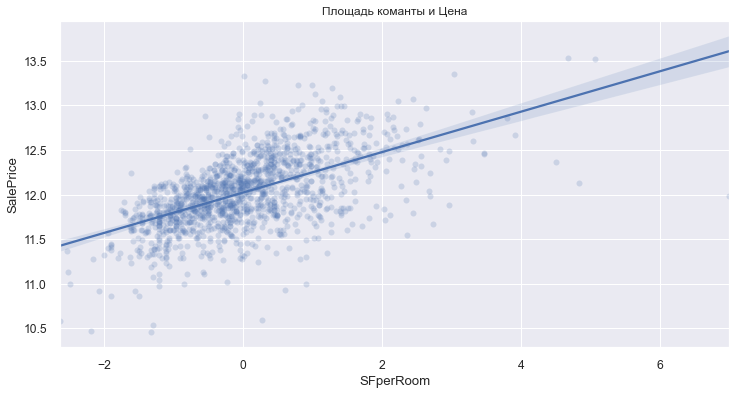

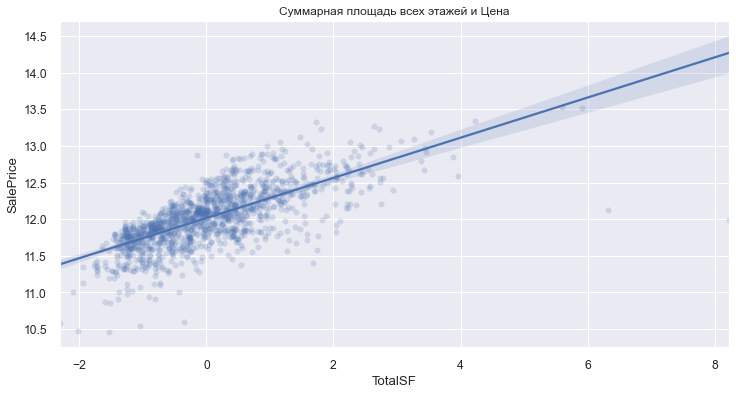

In [47]:
plt.figure(figsize = (12,6))
sns.regplot(data=train, x = 'SFperRoom', y='SalePrice', scatter_kws={'alpha':0.2})
plt.title('Площадь команты и Цена', fontsize = 12)
plt.show()

plt.figure(figsize = (12,6))
sns.regplot(data=train, x = 'TotalSF', y='SalePrice', scatter_kws={'alpha':0.2})
plt.title('Суммарная площадь всех этажей и Цена', fontsize = 12)
plt.show()

### Логарифмирование таргет-переменной

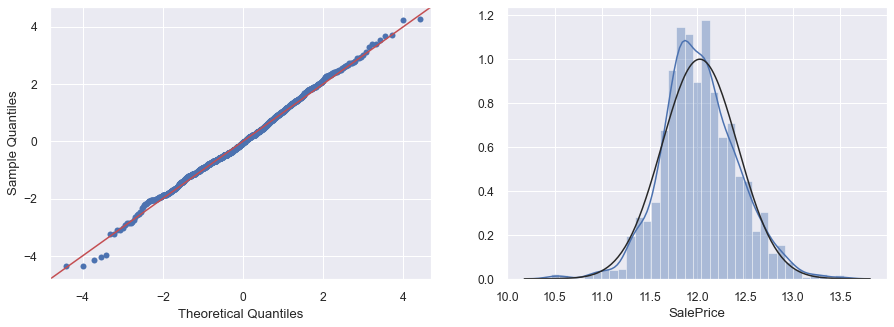

Коэффициент ассиметрии = 0.1212103673013655
Он -> 0, значит распределение прологарифмированной цены близко к нормальному закону
Коэффициент эксцесса = 0.8026555069117713
0 < Ek < 1 значит пик острый, но не сильно (при норм. распред = 0)


In [52]:
%matplotlib inline
import statsmodels.api as sm
from scipy import stats
fig, ax = plt.subplots(1,2, figsize= (15,5))

sm.qqplot(target, stats.t, distargs=(4,),fit=True, line="45", ax = ax[0])
sns.distplot(target, kde = True, hist=True, fit = norm, ax = ax[1])
plt.show()

print(f'Коэффициент ассиметрии = {skew(target)}')
print('Он -> 0, значит распределение прологарифмированной цены близко к нормальному закону')
print(f'Коэффициент эксцесса = {kurtosis(target)}')
print('0 < Ek < 1 значит пик острый, но не сильно (при норм. распред = 0)')

### Cross validation

**Обозначаем features и target переменные, пока что в features - все имеющиеся столбцы**

In [50]:
target = train['SalePrice']
x = train[list(train.loc[:, train.columns != 'SalePrice'].columns)].to_numpy()
y= target.to_numpy()
x.shape, y.shape

((1460, 273), (1460,))

**Делим x и y на обучающую и тестовую выборки (cross validation)**

In [53]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=1)
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((1022, 273), (438, 273), (1022,), (438,))

# Модели - прогнозирование цены

In [54]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

**Функция для выявления лучших параметров в результате GridSearch**

In [55]:
def gridsearch(reg, param_grid):
    
    cv = GridSearchCV(
    estimator=reg,
    param_grid=param_grid,
    scoring='neg_mean_squared_error', 
    cv=5, # количество фолдов
    verbose=4, # сколько печатать сообщений
    n_jobs=-1) # насколько параллелельно считаем
    
    cv.fit(x, y)
    
    best_params = cv.best_params_
    best_params = str(best_params).replace(':', '=').replace('{', '').replace('}', '')    
    best_params = str(best_params).replace("'", '')

    return best_params

**Функция вычисляющая MSE модели**

In [56]:
def MSE(model):
    model.fit(x, y)
    
    train_MSE = mean_squared_error(model.predict(x_train), y_train)**.5
    test_MSE = mean_squared_error(model.predict(x_test), y_test)**.5
  
    return  print("train MSE:", train_MSE), print("test MSE:", test_MSE)

**Функция, выводящая предсказанные цены**

In [57]:
def y_test_pred(model):
    model.fit(x, y)
    y_pred = np.exp(model.predict(test))
    return y_pred

# Линейная регрессия

kaggle score = 0.14296

In [58]:
gridsearch(LinearRegression(), {
    'fit_intercept': [True, False],
    'normalize': [True, False],
    'copy_X': [True, False],
    'n_jobs': [-1]})

Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    3.9s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    4.4s finished


'copy_X= True, fit_intercept= False, n_jobs= -1, normalize= True'

In [59]:
lin_reg = LinearRegression(copy_X= True, fit_intercept= True, n_jobs= -1, normalize= False)

In [60]:
MSE(lin_reg)

train MSE: 0.08967677755765191
test MSE: 0.10266671558978642


(None, None)

In [61]:
y_pred_LR = y_test_pred(LinearRegression(copy_X= True, fit_intercept= True, n_jobs= -1, normalize= False))
y_pred_LR

array([118225.54386585, 157746.71880318, 183444.1709966 , ...,
       175089.098009  , 116269.61086051, 224550.93145944])

**Сохраняем предсказания в csv-файл**

In [62]:
SalePrice_pred_LR = pd.concat([test_clean['Id'], pd.DataFrame(y_pred_LR, columns=['SalePrice'])], axis=1)
SalePrice_pred_LR.to_csv('SalePrice_pred_LR.csv', index=False)

In [63]:
x_test.shape, y_test.shape

((438, 273), (438,))

# Lasso

In [78]:
from sklearn.linear_model import LassoCV, RidgeCV, ElasticNetCV

In [79]:
gridsearch(LassoCV(), {'n_alphas': [100, 150, 70, 50]})

Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    3.6s finished


'n_alphas= 100'

In [80]:
lasso = LassoCV(n_alphas= 100)
MSE(lasso)

train MSE: 0.13897918181830252
test MSE: 0.13950925765736835


(None, None)

# Ridge

kaggle score = 0.12738

In [81]:
gridsearch(RidgeCV(), {'fit_intercept': [True, False],
                       'normalize': [True, False]})

Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    1.0s finished


'fit_intercept= True, normalize= False'

In [82]:
ridge = RidgeCV(fit_intercept= True, normalize= False)
MSE(ridge)

train MSE: 0.1064215232336996
test MSE: 0.1188150286582284


(None, None)

In [83]:
y_pred_Ridge = y_test_pred(ridge)

SalePrice_pred_Ridge = pd.concat([test_clean['Id'], pd.DataFrame(y_pred_Ridge, columns=['SalePrice'])], axis=1)
SalePrice_pred_Ridge.to_csv('SalePrice_pred_Ridge.csv', index=False)

# ElasticNetCV

kaggle score = 0.13907

In [84]:
gridsearch(ElasticNetCV(), {'l1_ratio': [.1, .5, .7, .9, .95, .99, 1],
                           'n_alphas': [100, 150, 70, 50],
                           'fit_intercept': [True, False],
                           'normalize': [True, False],
                           'max_iter': [100, 500, 150],
                           'random_state': [42]})

Fitting 5 folds for each of 336 candidates, totalling 1680 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    6.1s
[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:   19.3s
[Parallel(n_jobs=-1)]: Done 213 tasks      | elapsed:   48.1s
[Parallel(n_jobs=-1)]: Done 384 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 605 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:  4.6min
[Parallel(n_jobs=-1)]: Done 1193 tasks      | elapsed:  5.4min
[Parallel(n_jobs=-1)]: Done 1560 tasks      | elapsed:  6.2min
[Parallel(n_jobs=-1)]: Done 1680 out of 1680 | elapsed:  6.5min finished


'fit_intercept= True, l1_ratio= 0.1, max_iter= 100, n_alphas= 150, normalize= True, random_state= 42'

In [85]:
ElNetCV = ElasticNetCV(fit_intercept= True, l1_ratio= 0.1, max_iter= 100, n_alphas= 150, normalize= True, random_state= 42)
MSE(ElNetCV)

train MSE: 0.12009666224821243
test MSE: 0.1343994976658756


(None, None)

In [86]:
y_pred_ElNetCV = y_test_pred(ElNetCV)

SalePrice_pred_ElNetCV = pd.concat([test_clean['Id'], pd.DataFrame(y_pred_ElNetCV, columns=['SalePrice'])], axis=1)
SalePrice_pred_ElNetCV.to_csv('SalePrice_pred_ElNetCV.csv', index=False)

# DecisionTree

kaggle score = 0.18630

In [87]:
from sklearn.tree import DecisionTreeRegressor

gridsearch(DecisionTreeRegressor(), {
    'criterion': ['mse', 'friedman_mse', 'mae', 'poisson'],
    'splitter': ['best', 'random'],
    'max_depth': [2, 3, 5, 10, 20, None],
    'min_samples_split': [2, 5, 10],
    'max_features': [0.5, 'sqrt', None]})

Fitting 5 folds for each of 432 candidates, totalling 2160 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 320 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done 992 tasks      | elapsed:    9.8s
[Parallel(n_jobs=-1)]: Done 1324 tasks      | elapsed:   49.1s
[Parallel(n_jobs=-1)]: Done 1545 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 2160 out of 2160 | elapsed:  2.2min finished


'criterion= friedman_mse, max_depth= 20, max_features= 0.5, min_samples_split= 10, splitter= best'

In [88]:
dt = DecisionTreeRegressor(criterion= 'friedman_mse', max_depth= 20, max_features= 0.5, min_samples_split= 10, splitter= 'best')

MSE(dt)

train MSE: 0.06441523855194609
test MSE: 0.06323942682596452


(None, None)

In [89]:
y_pred_DT = y_test_pred(dt)

In [90]:
SalePrice_pred_DT = pd.concat([test_clean['Id'], pd.DataFrame(y_pred_DT, columns=['SalePrice'])], axis=1)
SalePrice_pred_DT.to_csv('SalePrice_pred_DT.csv', index=False)

# Ансамбли: случайный лес и градиентный бустинг

# RandomForest

kaggle score = 0.14128

In [91]:
from sklearn.ensemble import RandomForestRegressor

In [92]:
rf = RandomForestRegressor (n_estimators = 1000, random_state = 42)

MSE(rf)

train MSE: 0.04998758516182333
test MSE: 0.05492842241919403


(None, None)

In [93]:
y_pred_RF = y_test_pred(rf)

SalePrice_pred_RF = pd.concat([test_clean['Id'], pd.DataFrame(y_pred_RF, columns=['SalePrice'])], axis=1)
SalePrice_pred_RF.to_csv('SalePrice_pred_RF.csv', index=False)

# GradientBoosting

kaggle score = 0.13912

In [94]:
from sklearn.ensemble import  GradientBoostingRegressor

gbm = GradientBoostingRegressor(learning_rate=.12, n_estimators=50)
MSE(gbm)

train MSE: 0.0952586165419409
test MSE: 0.10318346948569126


(None, None)

In [95]:
y_pred_gbm = y_test_pred(gbm)

SalePrice_pred_gbm = pd.concat([test_clean['Id'], pd.DataFrame(y_pred_gbm, columns=['SalePrice'])], axis=1)
SalePrice_pred_gbm.to_csv('SalePrice_pred_gbm.csv', index=False)

# LGBMRegressor

kaggle score = 0.13424

In [96]:
from lightgbm import LGBMRegressor

l_gbm = LGBMRegressor(objective='regression')
MSE(l_gbm)

train MSE: 0.044334522996756554
test MSE: 0.051372960594833664


(None, None)

In [97]:
y_pred_LGBM = y_test_pred(l_gbm)

SalePrice_pred_LGBM = pd.concat([test_clean['Id'], pd.DataFrame(y_pred_LGBM, columns=['SalePrice'])], axis=1)
SalePrice_pred_LGBM.to_csv('SalePrice_pred_LGBM.csv', index=False)

In [98]:
gridsearch(LGBMRegressor(), {'boosting_type': ['gbdt', 'dart', 'goss', 'rf'],
                                'num_leaves': [31, 40, 27],
                                'learning_rate': [0.1, 0.2, 0.005, 0.09],
                                'class_weight ': ['balanced', None],
                                'n_estimators': [100, 150, 90], 
                                'objective' : ['regression']})

Fitting 5 folds for each of 288 candidates, totalling 1440 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    6.6s
[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:   18.7s
[Parallel(n_jobs=-1)]: Done 213 tasks      | elapsed:   36.8s
[Parallel(n_jobs=-1)]: Done 384 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 605 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 1440 out of 1440 | elapsed:  2.6min finished


[LightGBM] [Warning] Unknown parameter: balanced
[LightGBM] [Warning] Unknown parameter: class_weight


'boosting_type= gbdt, class_weight = balanced, learning_rate= 0.09, n_estimators= 150, num_leaves= 31, objective= regression'

In [99]:
l_gbm1 = LGBMRegressor(boosting_type= 'gbdt', class_weight ='balanced', learning_rate= 0.09, n_estimators= 150, num_leaves= 31, objective= 'regression')
MSE(l_gbm1)

train MSE: 0.05446037983423921
test MSE: 0.05239014556049763


(None, None)

# Stacking

kaggle score = 0.12323 (520)

In [100]:
from sklearn.ensemble import StackingRegressor

lin_reg, lasso, ridge, ElNetCV, df, rf, l_gbm

In [102]:
def stacking(estimator1, estimator2, final_estimator):
    estimators = [('1', estimator1),
                 ('2', estimator2)]
    stacking = StackingRegressor(estimators=estimators, 
                                final_estimator= final_estimator)
    stacking.fit(x, y)
    
    train_MSE = mean_squared_error(stacking.predict(x_train), y_train)**.5
    test_MSE = mean_squared_error(stacking.predict(x_test), y_test)**.5
    return print('train MSE: ', train_MSE), print('test MSE: ', test_MSE)

In [103]:
stacking(l_gbm, ridge, lin_reg)

train MSE:  0.06923267057007547
test MSE:  0.07913705463280084


(None, None)

In [104]:
estimators = [('1', l_gbm),
                 ('2', ridge)]
stacking = StackingRegressor(estimators=estimators, 
                            final_estimator= lin_reg)
stacking.fit(x, y)

y_pred_stacking = y_test_pred(stacking)

SalePrice_pred_stacking = pd.concat([test_clean['Id'], pd.DataFrame(y_pred_stacking, columns=['SalePrice'])], axis=1)
SalePrice_pred_stacking.to_csv('SalePrice_pred_stacking.csv', index=False)

# stacking clust

In [237]:
estimators = [('1', LGBMRegressor(objective='regression')),
             ('2',RidgeCV(fit_intercept=True, normalize=False))]
clf = StackingRegressor(estimators=estimators, final_estimator=LinearRegression(copy_X= True, fit_intercept= True, n_jobs= -1, normalize= False))
                        

In [238]:
clf.fit(x1, y1)

StackingRegressor(estimators=[('1', LGBMRegressor(objective='regression')),
                              ('2', RidgeCV(alphas=array([ 0.1,  1. , 10. ])))],
                  final_estimator=LinearRegression(n_jobs=-1))

In [239]:
print("train MSE:", mean_squared_error(clf.predict(x_train1), y_train1)**.5)
print("test MSE:", mean_squared_error(clf.predict(x_test1), y_test1)**.5)

train MSE: 0.06888320095121547
test MSE: 0.07768686824834092


In [270]:
test1 = test

In [264]:
test.shape

(1459, 273)

In [275]:
test1 = pd.concat([test1, pd.DataFrame(X_tsne[:1459, :].shape)], axis=1)
test1.fillna(0, inplace=True)

In [276]:
y_pred_stacking1 = np.exp(clf.predict(test1))

ValueError: Number of features of the model must match the input. Model n_features_ is 276 and input n_features is 275 

# Подведем итоги по моделям

In [106]:
data = {'Model': ['LinearRegression', 'Lasso', 'Ridge', 'ElasticNet', 'DecisionTree', 'RandomForest', 'lightgbm', 'Stacking', 'GradientBoosting'], 
        'test MSE': [0.10266, 0.1395, 0.1188, 0.13439, 0.09701, 0.05496, 0.05137, 0.07913, 0.10318],
       'kaggle score': [0.14296, 0.2830, 0.1273, 0.13907, 0.18630, 0.14128, 0.13424, 0.12323, 0.13912]}

model_results = pd.DataFrame(data)
model_results.sort_values('kaggle score')

,Model,test MSE,kaggle score
7,Stacking,0.07913,0.12323
2,Ridge,0.11880,0.12730
6,lightgbm,0.05137,0.13424
3,ElasticNet,0.13439,0.13907
8,GradientBoosting,0.10318,0.13912
5,RandomForest,0.05496,0.14128
0,LinearRegression,0.10266,0.14296
4,DecisionTree,0.09701,0.18630
1,Lasso,0.13950,0.28300


## Статистический тест на сравнение средних для разных категориальных вариантов одного признака

[ANOVA](https://www.analyticsvidhya.com/blog/2020/06/introduction-anova-statistics-data-science-covid-python/)

**Ho :** - существенной разницы между группами нет <br>
**H1 :** - между группами существует значительная разница

In [176]:
import scipy.stats as stats
import os

import statsmodels.api as sm
import statsmodels.stats.multicomp

from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns

# Hypothesis Testing

α = 0.05

In [177]:
quantitative = [f for f in train_clean.columns if train_clean.dtypes[f] != 'object']
quantitative.remove('SalePrice')
quantitative.remove('Id')
qualitative = [f for f in train_clean.columns if train_clean.dtypes[f] == 'object']

In [178]:
def anova_table(column:str):
    # Create ANOVA backbone table
    data = [['Between Groups', '', '', '', '', '', ''], ['Within Groups', '', '', '', '', '', ''], ['Total', '', '', '', '', '', '']] 
    anova_table = pd.DataFrame(data, columns = ['Source of Variation', 'SS', 'df', 'MS', 'F', 'P-value', 'F crit']) 
    anova_table.set_index('Source of Variation', inplace = True)

    # calculate SSTR and update anova table
    x_bar = train_clean['SalePrice'].mean()
    SSTR = train_clean.groupby(column).count() * (train_clean.groupby(column).mean() - x_bar)**2
    anova_table['SS']['Between Groups'] = SSTR['SalePrice'].sum()

    # calculate SSE and update anova table
    SSE = (train_clean.groupby(column).count() - 1) * train_clean.groupby(column).std()**2
    anova_table['SS']['Within Groups'] = SSE['SalePrice'].sum()

    # calculate SSTR and update anova table
    SSTR = SSTR['SalePrice'].sum() + SSE['SalePrice'].sum()
    anova_table['SS']['Total'] = SSTR

    # update degree of freedom
    anova_table['df']['Between Groups'] = train_clean[column].nunique() - 1
    anova_table['df']['Within Groups'] = train_clean.shape[0] - train_clean[column].nunique()
    anova_table['df']['Total'] = train_clean.shape[0] - 1

    # calculate MS
    anova_table['MS'] = anova_table['SS'] / anova_table['df']

    # calculate F 
    F = anova_table['MS']['Between Groups'] / anova_table['MS']['Within Groups']
    anova_table['F']['Between Groups'] = F

    # p-value
    anova_table['P-value']['Between Groups'] = 1 - stats.f.cdf(F, anova_table['df']['Between Groups'], anova_table['df']['Within Groups'])

    # F critical 
    alpha = 0.05
    # possible types "right-tailed, left-tailed, two-tailed"
    tail_hypothesis_type = "two-tailed"
    if tail_hypothesis_type == "two-tailed":
        alpha /= 2
    anova_table['F crit']['Between Groups'] = stats.f.ppf(1-alpha, anova_table['df']['Between Groups'], anova_table['df']['Within Groups'])

    # Final ANOVA Table
    return anova_table

**Гипотеза Н0 не отвергается (p-value>α, Fэмп > Fкрит (Fкрит не попало в критич. обл.) => All SalePrice means are equal**

In [179]:
anova_table('LandSlope')

,SS,df,MS,F,P-value,F crit
Source of Variation,,,,,,
Between Groups,2.46922e+10,2,1.23461e+10,1.95882,0.141396,3.69823
Within Groups,9.18322e+12,1457,6.30283e+09,,,
Total,9.20791e+12,1459,6.31111e+09,,,


In [180]:
anova_table('Street')

,SS,df,MS,F,P-value,F crit
Source of Variation,,,,,,
Between Groups,1.55053e+10,1,1.55053e+10,2.45929,0.117049,5.03428
Within Groups,9.19241e+12,1458,6.30481e+09,,,
Total,9.20791e+12,1459,6.31111e+09,,,
